In [1]:
%matplotlib inline

from importlib import reload
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.stats import invwishart, invgamma

# скачаем данные
dta = sm.datasets.macrodata.load_pandas().data
dta.index = pd.date_range('1959Q1', '2009Q3', freq='QS')

Посмотрим на данные.

In [2]:
dta.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-01-01,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-04-01,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-07-01,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-10-01,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-01-01,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


### Модель TVP-VAR в Statsmodels.

Основная цель использования Байесовских методов в данном случае - получить апостериорное распределение вектора скрытых состояний. 

Обычно, помимо MCMC, для этого используются две альтернативных процедуры:
* Фильтр Калмана
* Факторный алгоритм Холецкого

#### Одномерная модель

Для начала рассмотрим одномерную state space модель. Наблюдения: $y_t$, ненаблюдаемый тренд: $\mu_t$.

$$
\begin{aligned}
y_t = \mu_t + \varepsilon_t,\; \varepsilon_t \sim N(0, \sigma^2_{\textrm{irregular}}) \\[5pt]
\mu_t = \mu_{t-1} + \eta_t,\; \eta_t \sim N(0, \sigma^2_{\textrm{trend}}) \\
\end{aligned}
$$

То есть и наблюдаемая переменная, и скрытая - случайное блуждание. Мы заинтересованы насэмплировать наблюдения из апостериорного распределения для скрытого вектора состояния, то есть мы хотим получить выборку из

$$
p(\mu^t \; | \; y^t, \sigma^2_{irregular}, \sigma^2_{level})
$$

Где $\mu^t = (\mu_1, ..., \mu_T)'$ и $y^t = (y_1, ..., y_T)'$.

В `Statsmodels` модель скрытого уровня относится к более общему классу `Unobserved components` и может быть создана следующим образом:

In [3]:
# если посмотреть в справке, там куча разных спецификаций state space моделей
mod = sm.tsa.UnobservedComponents(dta.infl, 'llevel')

# Оценим sigma2_varepsilon, sigma2_eta с помощью ММП
res = mod.fit()
print(res.params)

# создадим объекты, которые могут сэмплировать из апостериорного распределения
sim_kfs = mod.simulation_smoother()              # default method is KFS
sim_cfa = mod.simulation_smoother(method='cfa')  # can specify CFA method
# у объектов есть метод simulate(), он генерирует новые выборки при каждом запуске

sigma2.irregular    3.373368
sigma2.level        0.744712
dtype: float64


In [4]:
%%time
NSIMULATIONS = 20

# создадим пустые датафреймы для хранения результатов симуляций
simulated_kfs = pd.DataFrame(np.zeros((mod.nobs, NSIMULATIONS)), index = dta.index)
simulated_cfa = pd.DataFrame(np.zeros((mod.nobs, NSIMULATIONS)), index = dta.index)

for i in range(NSIMULATIONS):
    # будем запускать симуляции и сохранять их результаты
    sim_kfs.simulate()
    simulated_kfs.iloc[:, i] = sim_kfs.simulated_state[0]
    
    sim_cfa.simulate()
    simulated_cfa.iloc[:, i] = sim_cfa.simulated_state[0]

Wall time: 62.5 ms


Нарисуем результаты.

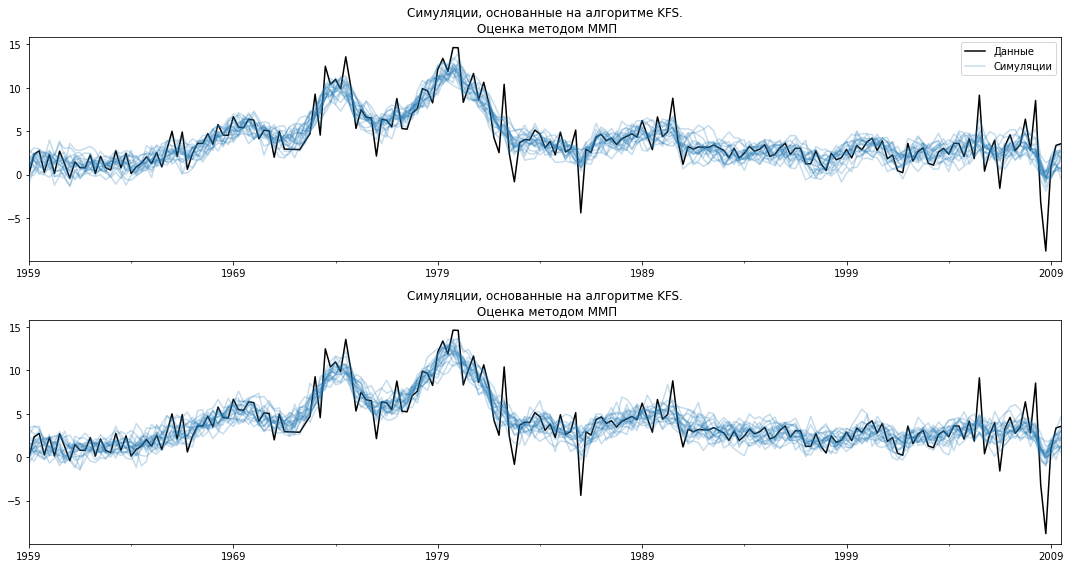

In [5]:
fig, ax = plt.subplots(2, figsize=(15, 8))

# собственно график
# KFS
dta.infl.plot(ax = ax[0], color='k')
ax[0].set_title('Симуляции, основанные на алгоритме KFS.\n Оценка методом ММП')
simulated_kfs.plot(ax=ax[0], color='C0', alpha=0.25, legend=False)

# CFA
dta.infl.plot(ax = ax[1], color='k')
ax[1].set_title('Симуляции, основанные на алгоритме KFS.\n Оценка методом ММП')
simulated_cfa.plot(ax=ax[1], color='C0', alpha=0.25, legend=False)

# добавим легенду, настроим график
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:2], ['Данные', 'Симуляции'])
fig.tight_layout();

#### Обновление параметров модели.

Каждый раз, когда мы обновляем параметры модели в объекте `mod`, это учитывается при запуске метода `simulate()`. Это удобно для MCMC, который обновляет параметры, делает выборку из апостериорного распределения для вектора состояний и затем обновляет параметры модели. То есть, видимо, авторы нам хотят сказать, что класс удобно сконструирован, чтобы MCMC мог сэмплить из апостериорного.

Попробуем изменить параметры модели так, чтобы тренд был более сглаженным, на примере KFS.

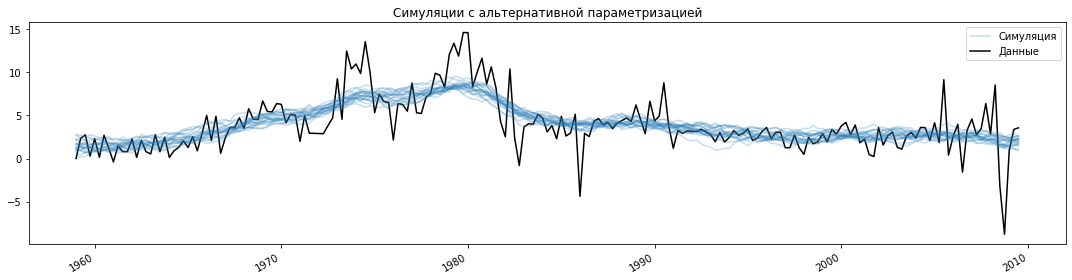

In [6]:
fig, ax = plt.subplots(figsize=(15, 4))

# обновим параметры модели
# сгладим дисперсию ошибки для ненаблюдаемого тренда
mod.update([4, 0.05])

# нарисуем симуляции
for _ in range(NSIMULATIONS):
    sim_kfs.simulate()
    ax.plot(dta.index, sim_kfs.simulated_state[0], 
            color='C0', alpha=0.25, label='Симуляция')

dta.infl.plot(ax=ax, color='k', label='Данные', zorder=-1)    
# легенда и все прочее
ax.set_title('Симуляции с альтернативной параметризацией')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:])
fig.tight_layout();

### Байесовское оценивание TVP-VAR с помощью MCMC.

Chan, Jliazkov (2009) оценили эту модель для 4 переменных (видимо, классический набор данных из `vars`):
* Реальный рост ВВП.
* Инфляция.
* Безработица.
* Краткосрочные % ставки.

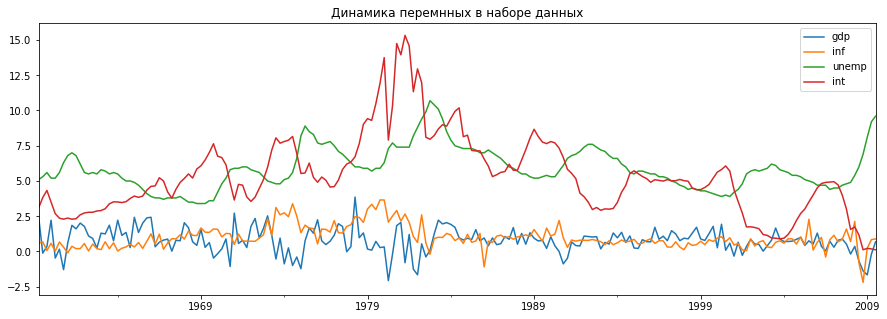

In [7]:
y = dta[['realgdp', 'cpi', 'unemp', 'tbilrate']].copy()
y.columns = ['gdp', 'inf', 'unemp', 'int']

# посчитаем рост ВВП и инфляцию
y[['gdp', 'inf']] = np.log(y[['gdp', 'inf']]).diff() * 100
y = y.iloc[1:]

fig, ax = plt.subplots(figsize=(15, 5))
y.plot(ax=ax)
ax.set_title('Динамика перемнных в наборе данных');

#### Собственно модель.

Обычно VAR(1) в сокращенной форме и векторном виде записывается так:

$$
y_t = \mu + \Phi y_{t-1} + \varepsilon_t, \; \varepsilon_t \sim N(0, H)
$$

$H$ - ковариационная матрица, видимо, диагональная.

Теперь переформатируем все параметры модели в вектор $\alpha_t = vec\big([\mu_t: \Phi_t]\big)$, где $vec$ - оператор, который переводит все столбцы матрицы в один вектор. Запишем уравнение для произвольного $i$-го коэффициента из вектора коэффициентов:

$$
\alpha_{i, t+1} = \alpha_{i, t} + \eta_{i,t},\; \eta_{i,t} \sim N(0, \sigma^2_i)
$$

То есть каждый параметр ведет себя как случайное блуждание.

Так как у нас $p$ переменных, то имеем $p$ наблюдений в векторе $\mu_t$ и $p^2$ наблюдений в марице $\Phi_t$, поэтому вектор $\alpha$ имеет размерность $p \cdot (p + 1) \times 1$.

Теперь запишем VAR(1) в формате модели "состояние-наблюдение" через SUR:

$$
\begin{gather}
    y_t = Z_t \alpha_t + \varepsilon_t, \;\; \varepsilon_t \sim N(0, H) \\[5pt]
    \alpha_{t+1} = \alpha_t + \eta_t, \;\; \eta_t \sim N \big(0, diag(\{\sigma^2_i\}) \big) 
\end{gather}
$$

Где 

$$
Z_t = 
\begin{bmatrix}
    1 & y^{T}_{t-1} & 0 & \dots & \; \; & 0 \\
    0 & 0 & 1 & y^T_{t-1} & \; \;  & 0 \\
    \vdots & \vdots & \vdots & \ddots & \ddots \\
    0 & 0 & 0 & 0 & 1 & y^T_{t-1}
\end{bmatrix}
$$

Прикол на самом деле в том, что $1$ в матрице выше - это вектор $(1, 0, 0, 0)$, а $0$ - это вектор $(0, 0, 0, 0)$, с размерностью самой нижней строки, авторы, видимо, немного напутали. У меня вышло, что матрица должна иметь размерность $p \times p \cdot (p+1)$. 

Возможен и другой вариант: допустим, $\alpha_t$ имеет вид

$$
\alpha_t = 
\begin{pmatrix}
    \mu_1 \\
    \alpha_{11} \\
    \alpha_{12} \\
    \alpha_{13} \\
    \alpha_{14} \\
    \mu_2 \\
    \alpha_{21} \\
    \alpha_{22} \\
    \vdots \\
    \mu_3 \\
    \vdots
\end{pmatrix}
+ \varepsilon_t
$$

Здесь я пренебрег индексами времени в векторе, но такой вариант выглядит более правдоподобным. Тогда векторную форму в матрице $Z_t$ имеют только нули.

Алгоритм CFA может работать только когда матрица $H$ имеет полный ранг, то есть все дисперсии, стоящие на диагонали, ненулевые.

Нам также нужно выбрать априорное распределение для $\alpha_1$. Как и в Chan, Jeliazkov (2009) мы предположим, что $\alpha_1 \sim N(0, 5I)$. Логичный выбор - стандартизированное нормальное распределение. Другие параметры - $H, \sigma^2_i$ - будут стабильны во времени в рамках оцениваемой модели.

#### Реализация модели в `Statsmodels`.

1. Создадим новый объект `TVPVAR` класса `sm.tsa.statespace.MLEModel`.
2. Загрузим в него известную информацию (временные ряды и матрицы, которые мы задали для системы состояние-наблюдение).
3. Зададим инициализацию $\alpha_1$.
4. Создадим метод для обновления матриц системы с помощью новых значений для ковариационной матрицы $H$ и дисперсий случайного блуждания $\sigma^2_i$.

В Statsmodels модель state space в общем виде реализована следующим образом:

$$
\begin{gather}
    y_t = d_t + Z_t \alpha_t + \varepsilon_t, \; \; \varepsilon_t \sim N(0, H_t) \\
    \alpha_{t+1} = c_t + T_t \alpha_t + R_t \eta_t, \; \; \eta_t \sim N(0, Q_t)
\end{gather}
$$

Наложим ограничения в рамках спецификации модели TVP-VAR(1):
* Константы равны нулю: $c_t = d_t = 0$
* Матрица $Z_t$ меняется во времени, но заполнена константами - единицами и векторами наблюдений.
* $T = I$
* $R = I$
* $H_t = H_{t-1} = H$
* $Q_t = Q_{t-1} = Q = diag(\{\sigma^2_i\})$

In [8]:
y.head()

data = np.arange(1, 7).reshape((-1, 2))
data
sm.tsa.lagmat(data, 
              # максимальный лаг, который включается в данные
              1, 
              # обрезать ли лишние строки сверху или снизу
              # если backward или forward, то пропуски по дефолту заполняются нулями
              trim='both', 
              # добавлять ли исходный ряд к матрице с лагами
              original='in')

,gdp,inf,unemp,int
1959-04-01,2.494213,0.584898,5.1,3.08
1959-07-01,-0.119295,0.683763,5.3,3.82
1959-10-01,0.349453,0.068120,5.6,4.33
1960-01-01,2.219018,0.577153,5.2,3.50
1960-04-01,-0.468455,0.033847,5.2,2.68


array([[1, 2],
       [3, 4],
       [5, 6]])

array([[3., 4., 1., 2.],
       [5., 6., 3., 4.]])

In [9]:
class TVPVAR(sm.tsa.statespace.MLEModel):
    # шаги 2-3 будем делать внутри конструктора класса
    def __init__(self, y):
        # матрица [y_t' : y_{t-1}'] для t = 2, ..., T
        augmented = sm.tsa.lagmat(y, 1, trim='both', original='in', use_pandas=True)
        # разделим на y_t и z_t = [1 : y_{t-1}']
        p = y.shape[1]
        y_t = augmented.iloc[:, :p]
        print(y_t)
        z_t = sm.add_constant(augmented.iloc[:, p:])
        
        # Вспомним, что длина вектора состояния равна p * (p + 1)
        k_states = p * (p + 1)
        super().__init__(y_t, exog=z_t, k_states=k_states)
        
        # по умолчанию матрицы модели "состояние-наблюдение" заполнены нулями
        # поэтому нет нужды руками прописывать, что c_t = d_t = 0
        
        # теперь зададим матрицу Z_t
        # -> self.k_endog = p размерность наблюдаемого вектора
        # -> self.k_states = p * (p + 1) размерность преобразованного вектора коэфф-тов
        # -> self.nobs = T число наблюдений y_t
        
        # создаем список из k_endog матриц, 
        # каждая из которых имеет размерность k_states строк х n_obs столбцов
        # то есть размерность Z_t (4, 20, 201)
        # размерность каждой матрицы (20, 201)
        self['design'] = np.zeros((self.k_endog, self.k_states, self.nobs))
        for i in range(self.k_endog):
            start = i * (self.k_endog + 1)
            end = start + self.k_endog + 1
            # i = 0 
            # -> start = 0, end = 5
            # self['design', 0, 0:5, :] = z_t.T
            # то есть в первую матрицу в строки 0-5 записываем z_t^T (5 x 201)
            # i = 1
            # -> start = 5, end = 10
            # self['design', 1, 5:10, :] = z_t.T
            # то есть во вторую матрицу в строки 5-10 записываем транспонированную z_t
            self['design', i, start:end, :] = z_t.T
            
        # зададим матрицу T = I
        self['transition'] = np.eye(k_states)
        
        # зададим матрицу R = I
        self['selection'] = np.eye(k_states)
        
        # Шаг 3: инициализируем вектор состояния как alpha_1 ~ N(0, 5I)
        self.ssm.initialize('known', stationary_cov=5 * np.eye(self.k_states))
        
    # Шаг 4: создадим метод для обновления ковариационных матриц H и Q
    def update_variances(self, obs_cov, state_cov_diag):
        self['obs_cov']  = obs_cov
        self['state_cov'] = np.diag(state_cov_diag)
        
    # наконец, определим человекочитаемые имена для каждого элемента
    # вектора состояния
    @property
    def state_names(self):
        state_names = np.empty((self.k_endog, self.k_endog + 1), dtype=object)
        for i in range(self.k_endog):
            endog_name = self.endog_names[i]
            state_names[i] = (
            [f"intercept.{endog_name}"] +
            [f"L1.{other_name}->{endog_name}" for other_name in self.endog_names]
            )
            
        return state_names.ravel().tolist()
        

In [10]:
mod = TVPVAR(y)

                 gdp       inf  unemp   int
1959-07-01 -0.119295  0.683763    5.3  3.82
1959-10-01  0.349453  0.068120    5.6  4.33
1960-01-01  2.219018  0.577153    5.2  3.50
1960-04-01 -0.468455  0.033847    5.2  2.68
1960-07-01  0.163288  0.674539    5.6  2.36
...              ...       ...    ...   ...
2008-07-01 -0.678136 -0.790362    6.0  1.17
2008-10-01 -1.380483 -2.197901    6.9  0.12
2009-01-01 -1.661198  0.233968    8.1  0.22
2009-04-01 -0.185125  0.841884    9.2  0.18
2009-07-01  0.686219  0.889402    9.6  0.12

[201 rows x 4 columns]


In [11]:
mod['design'].shape

print(mod['design'][0])
mod['design'][0].shape

print(mod['design'][3])
mod['design'][3].shape

(4, 20, 201)

[[ 1.          1.          1.         ...  1.          1.
   1.        ]
 [ 2.49421308 -0.11929521  0.34945327 ... -1.38048297 -1.66119797
  -0.18512476]
 [ 0.58489759  0.68376335  0.06811989 ... -2.19790092  0.23396779
   0.84188351]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


(20, 201)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.58489759  0.68376335  0.06811989 ... -2.19790092  0.23396779
   0.84188351]
 [ 5.1         5.3         5.6        ...  6.9         8.1
   9.2       ]
 [ 3.08        3.82        4.33       ...  0.12        0.22
   0.18      ]]


(20, 201)

In [12]:
dir(mod)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_clone_from_init_kwds',
 '_data_attr',
 '_fit_collinear',
 '_fit_zeros',
 '_fixed_params',
 '_fixed_params_index',
 '_forecasts_error_partial_derivatives',
 '_formula_max_endog',
 '_free_params_index',
 '_get_exog_names',
 '_get_extension_time_varying_matrices',
 '_get_index_label_loc',
 '_get_index_loc',
 '_get_index_with_final_state',
 '_get_init_kwds',
 '_get_prediction_index',
 '_handle_data',
 '_has_fixed_params',
 '_hessian_complex_step',
 '_hessian_finite_difference',
 '_hessian_oim',
 '_hessian_opg',
 '_hessian_param_defaults',
 '_hessian_param_names',
 '_index',
 '_index_dates',
 

In [13]:
# это z
mod.exog
mod.exog.shape

# это y_t
mod.endog
mod.endog.shape

array([[ 1.        ,  2.49421308,  0.58489759,  5.1       ,  3.08      ],
       [ 1.        , -0.11929521,  0.68376335,  5.3       ,  3.82      ],
       [ 1.        ,  0.34945327,  0.06811989,  5.6       ,  4.33      ],
       ...,
       [ 1.        , -1.38048297, -2.19790092,  6.9       ,  0.12      ],
       [ 1.        , -1.66119797,  0.23396779,  8.1       ,  0.22      ],
       [ 1.        , -0.18512476,  0.84188351,  9.2       ,  0.18      ]])

(201, 5)

array([[-1.19295211e-01,  6.83763348e-01,  5.30000000e+00,
         3.82000000e+00],
       [ 3.49453265e-01,  6.81198936e-02,  5.60000000e+00,
         4.33000000e+00],
       [ 2.21901795e+00,  5.77153189e-01,  5.20000000e+00,
         3.50000000e+00],
       [-4.68455328e-01,  3.38466749e-02,  5.20000000e+00,
         2.68000000e+00],
       [ 1.63288019e-01,  6.74538814e-01,  5.60000000e+00,
         2.36000000e+00],
       [-1.29063599e+00,  3.02064334e-01,  6.30000000e+00,
         2.29000000e+00],
       [ 5.92259126e-01, -1.00586765e-01,  6.80000000e+00,
         2.37000000e+00],
       [ 1.85345342e+00,  3.68324542e-01,  7.00000000e+00,
         2.29000000e+00],
       [ 1.60316392e+00,  2.00333957e-01,  6.80000000e+00,
         2.32000000e+00],
       [ 2.01528160e+00,  1.99933422e-01,  6.20000000e+00,
         2.60000000e+00],
       [ 1.77772593e+00,  5.64316850e-01,  5.60000000e+00,
         2.73000000e+00],
       [ 1.09805153e+00,  3.30961446e-02,  5.50000000e+00,
      

(201, 4)

Теперь нам нужно запустить MCMC с какой-то параметризацией. В качестве старта для H выберем выборочную ковариационную матрицу нашего датасета, $\sigma^2_i = 0.01$ согласно Chan, Jeliazkov. Посмотрим на выдачу модели без запуска MCMC, когда мы тупо пихнули стартовые параметры в модель.

Чтобы инциализировать значения, мы используем метод `update_variances`, который выполняет фильтрацию по Калману и сглаживание на основе заданных нами параметров. **Важно понимать, что этот шаг мы делаем для понимания работы модели, и на оценки, полученные в ходе этого шага, опираться не стоит**.

In [14]:
initial_obs_cov = np.cov(y.T)
initial_state_cov_diag = [0.01] * mod.k_states

# обновим H, Q
mod.update_variances(initial_obs_cov, initial_state_cov_diag)

# запустим фильтрацию по Калману и сглаживание
# (the [] is just an empty list that in some models might contain
# additional parameters. Here, we don't have any additional parameters
# so we just pass an empty list)
initial_res = mod.smooth([])

In [15]:
dir(initial_res)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_cache',
 '_cov_approx_centered',
 '_cov_approx_complex_step',
 '_cov_params_approx',
 '_cov_params_oim',
 '_cov_params_opg',
 '_cov_params_robust_approx',
 '_cov_params_robust_oim',
 '_data_attr',
 '_data_attr_model',
 '_data_in_cache',
 '_fixed_params',
 '_fixed_params_index',
 '_free_params_index',
 '_get_robustcov_results',
 '_has_fixed_params',
 '_news_previous_data',
 '_news_previous_results',
 '_news_updated_data',
 '_news_updated_results',
 '_rank',
 '_states',
 '_use_t',
 'aic',
 'aicc',
 'append',
 'apply',
 'bic',
 'bse',
 'conf_int',
 'cov_kwds',
 'cov_params',
 'cov_params_approx',
 'cov_params_de

In [16]:
initial_res.states.smoothed

,intercept.gdp,L1.gdp->gdp,L1.inf->gdp,L1.unemp->gdp,L1.int->gdp,intercept.inf,L1.gdp->inf,L1.inf->inf,L1.unemp->inf,L1.int->inf,intercept.unemp,L1.gdp->unemp,L1.inf->unemp,L1.unemp->unemp,L1.int->unemp,intercept.int,L1.gdp->int,L1.inf->int,L1.unemp->int,L1.int->int
1959-07-01,-1.384554,-0.175949,-0.384617,0.292375,0.172421,0.804642,0.104558,-0.588556,-0.101302,0.088413,0.421506,-0.106481,0.027352,0.956308,0.001953,0.607765,0.053832,0.116985,-0.013857,0.798457
1959-10-01,-1.386409,-0.174019,-0.384852,0.297625,0.175583,0.803746,0.098518,-0.591199,-0.114281,0.080874,0.421433,-0.108979,0.026871,0.953549,-0.000865,0.608763,0.053397,0.117092,-0.014994,0.799384
1960-01-01,-1.384760,-0.172508,-0.382691,0.321440,0.192126,0.806619,0.092030,-0.591264,-0.107287,0.087731,0.421603,-0.111506,0.026556,0.952078,-0.002754,0.608251,0.053143,0.116166,-0.024133,0.794543
1960-04-01,-1.396622,-0.175718,-0.381450,0.269596,0.150169,0.807185,0.084735,-0.591487,-0.113209,0.084601,0.423318,-0.113493,0.026346,0.959258,0.002046,0.608331,0.053095,0.115281,-0.029958,0.792265
1960-07-01,-1.403169,-0.167133,-0.377142,0.245391,0.126815,0.812851,0.088757,-0.588766,-0.092610,0.099320,0.424971,-0.115618,0.026101,0.966117,0.006630,0.608509,0.053266,0.114452,-0.035272,0.790331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-07-01,-1.511756,-0.021072,0.134454,0.122229,0.147035,0.887542,0.150130,-0.129557,-0.134304,-0.087932,0.516359,-0.174025,-0.042609,1.020876,-0.042339,0.632097,0.099275,-0.054101,-0.095531,0.860023
2008-10-01,-1.519074,-0.011176,0.156434,0.089049,0.139248,0.867449,0.154643,-0.104443,-0.226750,-0.124683,0.516474,-0.175913,-0.044328,1.020890,-0.042776,0.635249,0.098703,-0.056967,-0.079128,0.865200
2009-01-01,-1.519458,-0.005983,0.172934,0.097473,0.139573,0.881023,0.136327,-0.105938,-0.117196,-0.122044,0.517044,-0.178111,-0.046408,1.023643,-0.042678,0.633724,0.101302,-0.056137,-0.090789,0.864904
2009-04-01,-1.514066,-0.008763,0.176739,0.145750,0.140592,0.892079,0.121485,-0.101899,-0.025013,-0.119707,0.516948,-0.179388,-0.047022,1.021795,-0.042660,0.632654,0.103273,-0.056307,-0.099308,0.864664


Переменная `initial_res` содержит результаты Калмановского фильтра на основе введенных параметров. Нам нужны оценки $E[\alpha_t \; | \; y^t, H, \{ \sigma^2_i\}]$.

Напишем функцию, которая будет рисовать оценки коэффициентов для наблюдаемых переменных.

In [17]:
def plot_coefficients_by_equation(states):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # мы определили Z_t так, что первые 5 элементов вектора состояния
    # относятся к первой переменной в y_t, то есть GDP growth
    ax = axes[0, 0]
    states.iloc[:, :5].plot(ax=ax)
    ax.set_title('GDP growth')
    ax.legend()
    
    ax = axes[0, 1]
    states.iloc[:, 5:10].plot(ax=ax)
    ax.set_title('Inflation rate')
    ax.legend()
    
    ax = axes[1, 0]
    states.iloc[:, 10:15].plot(ax=ax)
    ax.set_title('Unemployment')
    ax.legend()
    
    ax = axes[1, 1]
    states.iloc[:, 15:20].plot(ax=ax)
    ax.set_title('Interest rate')
    ax.legend()
    
    return ax

Нарисуем, и увидим, что параметры достаточно сильно варьируются во времени.

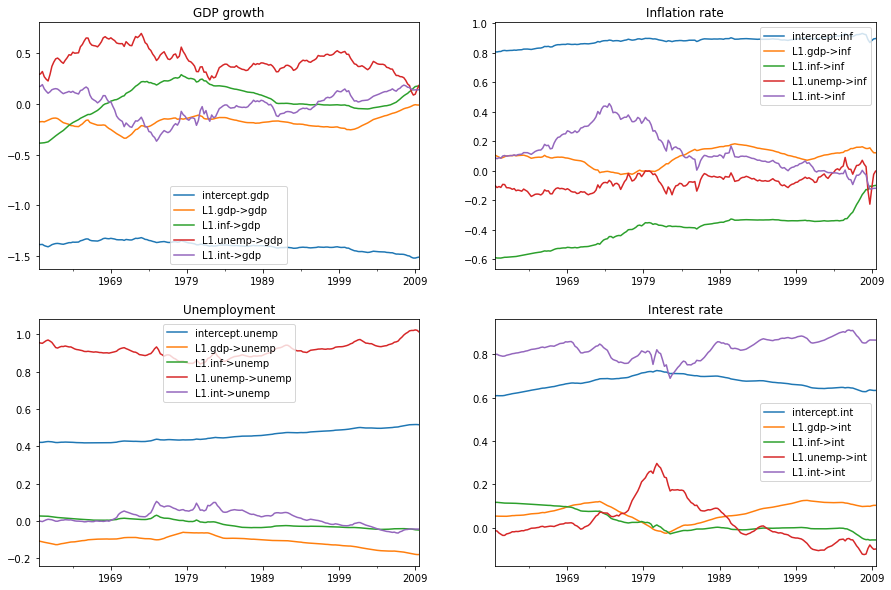

In [18]:
plot_coefficients_by_equation(initial_res.states.smoothed);

In [19]:
np.dot(mod['design'], initial_res.states.smoothed).shape

(4, 20, 20)

In [20]:
mod['design'].T.shape

(201, 20, 4)

In [21]:
mod['design'][0]
mod['design'][3]

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 2.49421308, -0.11929521,  0.34945327, ..., -1.38048297,
        -1.66119797, -0.18512476],
       [ 0.58489759,  0.68376335,  0.06811989, ..., -2.19790092,
         0.23396779,  0.84188351],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.58489759,  0.68376335,  0.06811989, ..., -2.19790092,
         0.23396779,  0.84188351],
       [ 5.1       ,  5.3       ,  5.6       , ...,  6.9       ,
         8.1       ,  9.2       ],
       [ 3.08      ,  3.82      ,  4.33      , ...,  0.12      ,
         0.22      ,  0.18      ]])

Разберемся, почему Z_t задается именно таким образом. Надо поэкспериментировать с маленькой матрицей. Пусть будет 2 переменных и 5 наблюдений.

In [22]:
Z_t = np.array([
               [[1, 1, 1, 1, 1],
                [2, 3, 4, 5, 6],
                [7, 8, 9, 10, 11],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0]],
               [[0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [1, 1, 1, 1, 1],
                [2, 3, 4, 5, 6],
                [7, 8, 9, 10, 11]],

])

alpha = np.array(
         [[1.1, 2.1, 3.1, 2.1, 4.1, 6.1],
         [1.2, 2.2, 3.2, 2.2, 4.2, 6.2], 
         [1.3, 2.3, 3.3, 2.3, 4.3, 6.3], 
         [1.4, 2.4, 3.4, 2.4, 4.4, 6.4], 
         [1.5, 2.5, 3.5, 2.5, 4.5, 6.5]]
)

Вопрос. Как перемножить матрицы так, чтобы получить вектор наблюдений?

In [23]:
(Z_t * alpha.T)

array([[[ 1.1,  1.2,  1.3,  1.4,  1.5],
        [ 4.2,  6.6,  9.2, 12. , 15. ],
        [21.7, 25.6, 29.7, 34. , 38.5],
        [ 0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ]],

       [[ 0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ],
        [ 2.1,  2.2,  2.3,  2.4,  2.5],
        [ 8.2, 12.6, 17.2, 22. , 27. ],
        [42.7, 49.6, 56.7, 64. , 71.5]]])

In [24]:
(Z_t * alpha.T).shape

(2, 6, 5)

In [25]:
# суммируем вдоль второй оси
(Z_t * alpha.T).sum(axis=1)

array([[ 27. ,  33.4,  40.2,  47.4,  55. ],
       [ 53. ,  64.4,  76.2,  88.4, 101. ]])

In [26]:
(mod['design'] * initial_res.states.smoothed.values.T).sum(axis=1).shape

(4, 201)

Нарисуем прогнозы переменных, полученные внутри модели.

In [34]:
assert y_hat.shape == y.iloc[1:].shape

In [50]:
y_hat.columns


Index(['gdp', 'inf', 'unemp', 'int'], dtype='object')

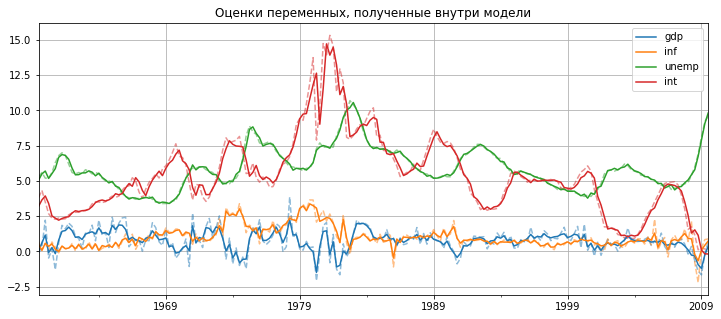

In [59]:
from matplotlib.lines import Line2D

y_hat = (mod['design'] * initial_res.states.smoothed.values.T).sum(axis=1)
y_hat = pd.DataFrame(y_hat).T
y_hat.index = y.index[1:]
y_hat.columns = y.columns

# зададим цветовую палитру
colors = ['C0', 'C1', 'C2', 'C3']
# сгенерируем линии для легенды
custom_lines = [Line2D([0], [0], color=c, lw=1.5) for c in colors]

# зададим словарь с цветами для столбцов
style_dict = dict(zip(y.columns, ['C0', 'C1', 'C2', 'C3']))

fig, axes = plt.subplots(figsize=(12, 5))
ax = axes
y.iloc[1:].plot(ax=axes, alpha=0.5, legend=False, linestyle='--', style=style_dict)
y_hat.plot(ax=axes, legend=False, style=style_dict)
ax.set_title('Оценки переменных, полученные внутри модели')
ax.legend(custom_lines, y_hat.columns)
ax.grid(True);           

Победа! Теперь посмотрим, что есть в объекте, когда мы уже оценили модель. Хотелось бы понять, где находятся прогнозы, которые мы считали выше вручную.

In [60]:
dir(initial_res)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_cache',
 '_cov_approx_centered',
 '_cov_approx_complex_step',
 '_cov_params_approx',
 '_cov_params_oim',
 '_cov_params_opg',
 '_cov_params_robust_approx',
 '_cov_params_robust_oim',
 '_data_attr',
 '_data_attr_model',
 '_data_in_cache',
 '_fixed_params',
 '_fixed_params_index',
 '_free_params_index',
 '_get_robustcov_results',
 '_has_fixed_params',
 '_news_previous_data',
 '_news_previous_results',
 '_news_updated_data',
 '_news_updated_results',
 '_rank',
 '_states',
 '_use_t',
 'aic',
 'aicc',
 'append',
 'apply',
 'bic',
 'bse',
 'conf_int',
 'cov_kwds',
 'cov_params',
 'cov_params_approx',
 'cov_params_de

In [61]:
initial_res.aic, initial_res.bic, initial_res.forecasts.shape

(2685.949472892317, 2685.949472892317, (4, 201))

Перейдем к байесовскому оцениванию.

### Байесовское оценивание с помощью MCMC.

Будем использовать сэмплировщик Гиббса из статьи, описанной выше (алгоритм 2). Априорные сопряженные распределения для ковариационных матриц:

$$
\begin{aligned}
    H & \sim \mathcal{IW}(\nu_1^0, S_1^0) \\[7pt]
    \sigma^2_i & \sim \mathcal{IG} \bigg(\frac{\nu^0_{i2}}{2}, \frac{S^0_{i2}}{2} \bigg)
\end{aligned}
$$

Где $\mathcal{IW}$ - обратное распределение Уишарта, а $\mathcal{IG}$ = обратное гамма-распределение. Априорные гиперпараметры:

$$
\begin{aligned}
    v^0_1 = T + 3,  & \quad S_1^0 = I \\
    v_{i2}^0 =6, & \quad S_{i2}^0 = 0.01 \quad \text{для каждого} ~ i \\
\end{aligned}
$$

In [65]:
# априорные гиперпараметры

# для H априорное распределение inverse-Wishart(v_1^0=k + 3, S10=I)
v10 = mod.k_endog + 3
S10 = np.eye(mod.k_endog)

# для ков. матрицы коэффициентов априорное 
# inverse-Gamma(v_{i2}^0 / 2 = 3, S+{i2}^0 / 2 = 0.005)
vi20 = 6
Si20 = 0.01

Прежде чем запускать MCMC, необходимо: 
1. Создать пустые массивы для:
 * Вектора состояния
 * Ковариационной матрицы вектора наблюдений
 * Ковариационной матрицы вектора состояния
2. Загрузить стартовые значения $H$ и $Q$ в эти массивы.
3. Создать объект для симуляций и сглаживания, связанный с объектом `TVPVAR`, чтобы сэмплировать скрытый вектор состояний.

In [66]:
# настройка сэмплера Гиббса
niter = 11000
nburn = 1000

# 1. массивы для хранения информации
store_states = np.zeros((niter + 1, mod.nobs, mod.k_states))
store_obs_cov = np.zeros((niter + 1, mod.k_endog, mod.k_endog))
store_state_cov = np.zeros((niter + 1, mod.k_states))

# 2. Загрузим стартовые занчения
store_obs_cov[0] = initial_obs_cov
store_state_cov[0] = initial_state_cov_diag
mod.update_variances(store_obs_cov[0], store_state_cov[0])

# 3. Инициализируем сэмплировщик
sim = mod.simulation_smoother(method='cfa')

Как и прежде, мы могли бы использовать сэмплировщик или на основе фильра Калмана, или на основе факторного алгоритма Холецкого.

In [67]:
%%time
for i in range(niter):
    mod.update_variances(store_obs_cov[i], store_state_cov[i])
    sim.simulate()
    
    # 1. Сэмплируем состояния
    store_states[i+1] = sim.simulated_state.T
    
    # симулируем ковариационную матрицу наблюдений
    fitted = np.matmul(mod['design'].transpose(2, 0, 1),
                       store_states[i + 1][..., None])[..., 0]
    resid = mod.endog - fitted
    store_obs_cov[i+1] = invwishart.rvs(v10 + mod.nobs, S10 + resid.T @ resid)
    
    # симулируем ковариационную матрицу вектора состояний
    resid = store_states[i + 1, 1:] - store_states[i + 1, :-1]
    sse = np.sum(resid**2, axis=0)
    
    for j in range(mod.k_states):
        rv = invgamma.rvs((vi20 + mod.nobs - 1) / 2, scale=(Si20 + sse[j]) / 2)
        store_state_cov[i + 1, j] = rv

Wall time: 37 s


Теперь мы можем удалить `nburn` сэмплов из апостериорного наблюдения и нарисовать средние значения из апостериорного распределения параметров.

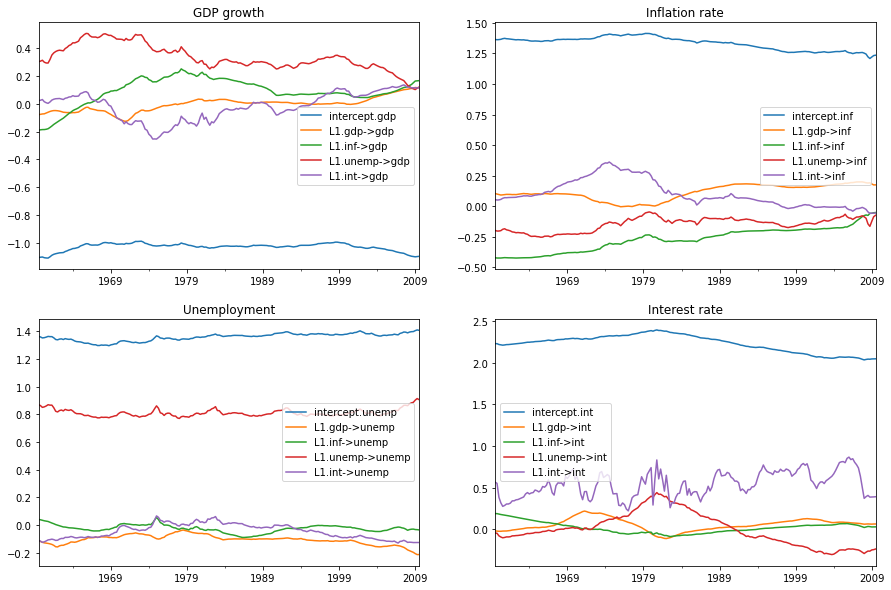

In [68]:
state_posterior_mean = pd.DataFrame(
    np.mean(store_states[nburn + 1:], axis=0),
    index = mod._index, columns = mod.state_names
)

# нарисуем 
plot_coefficients_by_equation(state_posterior_mean);

Теперь посмотрим на апостериорные распределения элементов ковариационных матриц с помощью `arviz`.

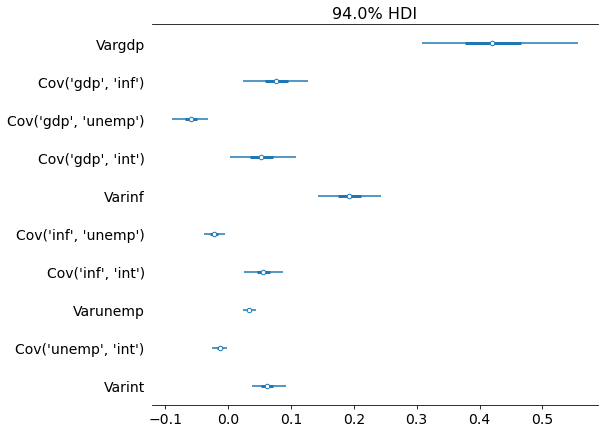

In [71]:
import arviz as az

# вытащим наблюдения, связанные с ковариационными матрицами
az_obs_cov = az.convert_to_inference_data({
    (
     f"Var{mod.endog_names[i]}" if i == j else
     f"Cov{mod.endog_names[i], mod.endog_names[j]}"
    ):
    store_obs_cov[nburn + 1:, i, j]
    for i in range(mod.k_endog) for j in range(i, mod.k_endog)
})

# нарисуем доверительные интервалы
az.plot_forest(az_obs_cov, figsize=(8, 7));

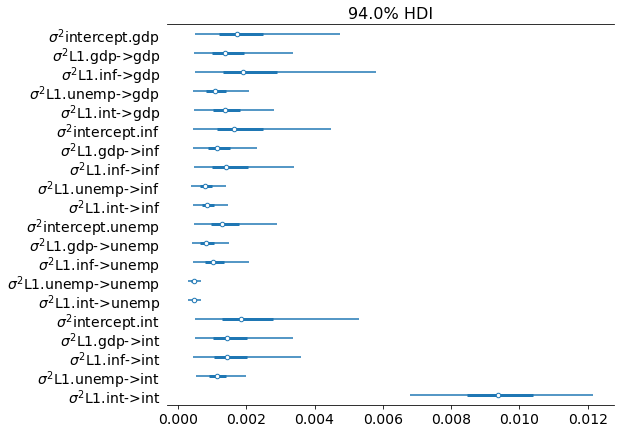

In [73]:
# соберем оценки дисперсий вектора состояния
az_state_cov = az.convert_to_inference_data({
    f"$\sigma^2${mod.state_names[i]}": store_state_cov[nburn + 1:, i]
    for i in range(mod.k_states)
})

az.plot_forest(az_state_cov, figsize=(8, 7));

Несмотря на то, что параметры авторегрессии меняются с течением времени, имеет смысл также вытащить и их распределения.

In [76]:
print(f"Размерность матрицы с выборкой из апост.: {store_states.shape}")

Размерность матрицы с выборкой из апост.: (11001, 201, 20)


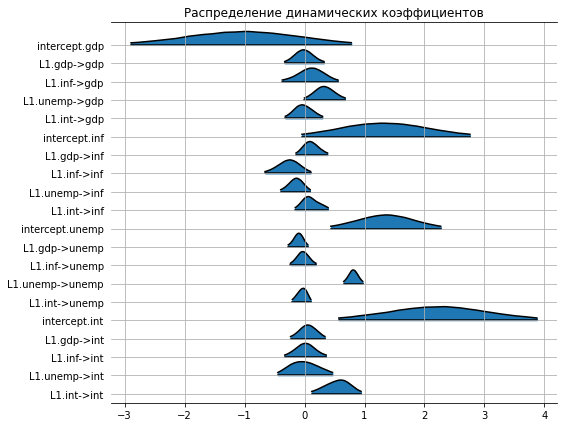

In [135]:
# сначала flatten(), потом разложим в строки с 20 столбцами
param_data = store_states.flatten().reshape(-1, 20).T
param_data[nburn + 1:, 5]
states_post = {f"{mod.state_names[i]}": 
               param_data[i,nburn+1:]
               for i in range(mod.k_states)}

axes = az.plot_forest(az.convert_to_inference_data(states_post), 
               figsize=(8, 7), 
               kind='ridgeplot')
axes[0].set_title('Распределение динамических коэффициентов')
axes[0].grid(True);

### Байесовская state-space линейная регрессия.

Полезные ссылки по `numpy`:
1. https://towardsdatascience.com/reshaping-numpy-arrays-in-python-a-step-by-step-pictorial-tutorial-aed5f471cf0b
2. https://stackoverflow.com/questions/32034237/how-does-numpys-transpose-method-permute-the-axes-of-an-array

Надо еще порыться в модели, где там в объекте запрятан прогноз.

In [158]:
print(initial_res.summary())

                                 Statespace Model Results                                 
Dep. Variable:     ['gdp', 'inf', 'unemp', 'int']   No. Observations:                  201
Model:                                     TVPVAR   Log Likelihood               -1342.975
Date:                            Mon, 02 May 2022   AIC                           2685.949
Time:                                    23:57:34   BIC                           2685.949
Sample:                                07-01-1959   HQIC                          2685.949
                                     - 07-01-2009                                         
Covariance Type:                              opg                                         
Ljung-Box (L1) (Q):     0.16, 0.09, 4.94, 0.00   Jarque-Bera (JB):   26.84, 716.54, 22.32, 375.06
Prob(Q):                0.69, 0.77, 0.03, 0.95   Prob(JB):                 0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H): 0.39, 3.58, 0.42, 1.80   Skew:                   0.4

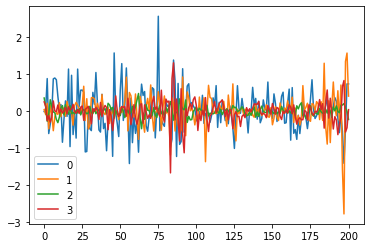

In [161]:
e = pd.DataFrame(initial_res.standardized_forecasts_error).T
e.plot();

Попробуем посчитать ошибку на обучающей выборке.

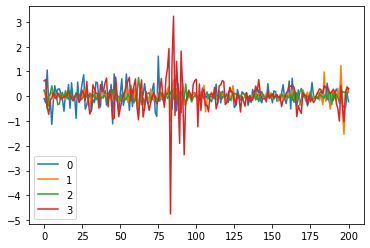

In [173]:
e = pd.DataFrame((y.iloc[1:].values - y_hat.values))
e.head()
e.plot();

In [177]:
e.head()

,0,1,2,3
0,-0.093097,0.206908,0.244895,0.620969
1,-0.269887,-0.022883,0.096689,0.673364
2,1.058162,-0.000416,-0.504155,-0.439965
3,-0.389249,-0.327405,0.018019,-0.729831
4,-0.114970,0.138588,0.078408,-0.162102


In [182]:
np.sqrt((e ** 2).sum(axis=0)) / e.shape[0]

0    0.026670
1    0.018008
2    0.010738
3    0.045562
dtype: float64

In [187]:
np.sqrt(np.average((y.iloc[1:].values - y_hat.values) ** 2, axis= 0))

array([0.37811269, 0.25530395, 0.15223615, 0.64595165])

Сравним с ошибкой константной модели. На самом деле, это не совсем честно, надо сравнивать с random walk.

In [201]:
mean_preds = np.tile(np.average(y, axis=0), 
                     reps=y.shape[0]-1).reshape(y.shape[0]-1, -1)
e_mean = y.iloc[1:].values - mean_preds
np.sqrt(np.average((e_mean) ** 2, axis= 0))


array([0.87136948, 0.81184862, 1.46113666, 2.80003542])